# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1001  2020-03-10  Alabama  Autauga       55869          0              False   
      2020-03-11  Alabama  Autauga       55869          0              False   
      2020-03-12  Alabama  Autauga       55869          0              False   
      2020-03-13  Alabama  Autauga       55869          0              False   
      2020-03-14  Alabama  Autauga       55869          0              False   
...                   ...      ...         ...        ...                ...   
56039 2020-05-13  Wyoming    Teton       23464         99              False   
      2020-05-14  Wyoming    Teton       23464         99              False   
      2020-05-15  Wyoming    Teton       23464         99              False   
      2020-05-16  Wyoming    Teton       23464        100              False   
      2020-05-17  Wyoming    Teton       23464        100              False   

                  Exponential    Logistic     Logistic2  
FIPS  Date                                               
1001  2020-03-10          1.0    1.452369  1.774478e-07  
      2020-03-11          1.0    1.561110  2.509953e-07  
      2020-03-12          1.0    1.677930  3.549484e-07  
      2020-03-13          1.0    1.803420  5.018344e-07  
      2020-03-14          1.0    1.938211  7.093184e-07  
...                       ...         ...           ...  
56039 2020-05-13          1.0  100.341289  9.734251e+01  
      2020-05-14          1.0  100.505990  9.734144e+01  
      2020-05-15          1.0  100.650322  9.734072e+01  
      2020-05-16          1.0  100.776758  9.734024e+01  
      2020-05-17          1.0  100.887478  9.733992e+01  

[63135 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1001  2020-03-10  Alabama  Autauga       55869          0                  0   
      2020-03-11  Alabama  Autauga       55869          0                  0   
      2020-03-12  Alabama  Autauga       55869          0                  0   
      2020-03-13  Alabama  Autauga       55869          0                  0   
      2020-03-14  Alabama  Autauga       55869          0                  0   
...                   ...      ...         ...        ...                ...   
56039 2020-05-13  Wyoming    Teton       23464         99                  0   
      2020-05-14  Wyoming    Teton       23464         99                  0   
      2020-05-15  Wyoming    Teton       23464         99                  0   
      2020-05-16  Wyoming    Teton       23464        100                  0   
      2020-05-17  Wyoming    Teton       23464        100                  0   

                  Exponential    Logistic     Logistic2  
FIPS  Date                                               
1001  2020-03-10          1.0    1.452369  1.774478e-07  
      2020-03-11          1.0    1.561110  2.509953e-07  
      2020-03-12          1.0    1.677930  3.549484e-07  
      2020-03-13          1.0    1.803420  5.018344e-07  
      2020-03-14          1.0    1.938211  7.093184e-07  
...                       ...         ...           ...  
56039 2020-05-13          1.0  100.341289  9.734251e+01  
      2020-05-14          1.0  100.505990  9.734144e+01  
      2020-05-15          1.0  100.650322  9.734072e+01  
      2020-05-16          1.0  100.776758  9.734024e+01  
      2020-05-17          1.0  100.887478  9.733992e+01  

[63135 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 1.45236888 1.56110969 1.6779297 1.803...,[1.77447803e-07 2.50995262e-07 3.54948362e-07 5...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 2.57287919 2.86127469 3.18158681 3.537...,[2.24782961e-01 2.78630288e-01 3.45248445e-01 4...
1013,Alabama,Butler,19448,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[8.72249124e-03 1.04226431e-02 1.24541692e-02 1...,[2.45092359e-01 2.71296116e-01 2.99929789e-01 3...
1015,Alabama,Calhoun,113605,[ 0 0 0 0 0 0 0 0 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 1.83955484 2.05484255 2.29487023 2.562...,[1.61907557e-04 2.48814446e-04 3.82370951e-04 5...
1017,Alabama,Chambers,33254,[ 0 0 0 0 0 0 0 0 0 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.09698636 1.20337908 1.320...,[ 1.2563206 1.49786823 1.78559018 2.128...,[ 0.59115411 0.72779069 0.89578444 1.102...
...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.10127071 1.21279717 1.335...,[ 18.33674957 19.92153259 21.63652355 23.491...,[ 1.7202925 2.17717658 2.75229679 3.474...
55139,Wisconsin,Winnebago,171907,[ 0 0 0 0 1 1 3 3 5 5 5 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 3.71663238 3.9456146 4.18846356 4.445...,[ 3.33516736 3.56400346 3.80758097 4.066...
56013,Wyoming,Fremont,39261,[ 0 0 0 0 1 1 1 8 8 8 9 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1...,[ 4.02380176 4.3190724 4.63576529 4.975...,[ 3.87501415 4.16950833 4.48585047 4.825...


In [6]:
# Read in the parameters of the curves in `curves`
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.000000,69.0,220.507559,0.072698,69.000000,1419.349992,0.348968,65.279688,53.714540,3.236958,14.382468,33.278405,43.598479
1003,Alabama,Baldwin,223234,0.000000,69.0,253.546021,0.107391,42.650713,535.638267,0.695515,45.357924,519.301303,0.040293,69.000000,21.466305,27.074776
1013,Alabama,Butler,19448,0.000000,69.0,333.446715,0.178081,59.250087,323.151902,0.119303,58.410333,324.666982,0.187087,58.923584,9.651052,20.775420
1015,Alabama,Calhoun,113605,0.000000,69.0,128.728254,0.112374,37.675949,132.831373,0.429680,31.692333,129.950014,0.100274,37.259914,16.734170,15.736972
1017,Alabama,Chambers,33254,0.092567,0.0,311.776092,0.176634,31.194822,56.398120,8.364028,29.968907,447.777401,0.020263,17.395100,23.179009,28.260747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,0.096465,0.0,456.757453,0.086515,36.690306,932.476564,0.351420,64.329276,940.493799,0.032788,69.000000,12.643473,17.395936
55139,Wisconsin,Winnebago,171907,0.000000,69.0,249.030866,0.060721,69.000000,511.082241,8.922810,68.373833,293.599386,0.053269,69.000000,0.000001,37.173960
56013,Wyoming,Fremont,39261,0.000000,69.0,413.991045,0.071534,64.638514,566.841775,10.000000,69.000000,571.117421,0.066692,63.593953,0.000000,69.000000


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,-0.868203,0.982594,0.998399
1003,Alabama,Baldwin,223234,-1.201186,0.993653,0.999072
1013,Alabama,Butler,19448,-0.372575,0.997741,0.997889
1015,Alabama,Calhoun,113605,-1.383566,0.979270,0.988572
1017,Alabama,Chambers,33254,0.025632,0.994898,0.998625
...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,0.077550,0.983948,0.998768
55139,Wisconsin,Winnebago,171907,-1.184843,0.986783,0.987093
56013,Wyoming,Fremont,39261,-1.039177,0.989724,0.989457


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,915.000000,915.000000,915.000000
mean,-0.332176,0.987286,0.991283
std,0.896167,0.013706,0.031210
min,-3.460995,0.877621,0.649832
25%,-1.013827,0.984889,0.995778
50%,-0.214386,0.991174,0.997965
75%,0.428078,0.995294,0.998900
max,0.995196,0.999327,0.999910


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 2 of 915 counties have R^2 >= 0.99
 Log_R^2: 520 of 915 counties have R^2 >= 0.99
Log2_R^2: 818 of 915 counties have R^2 >= 0.99



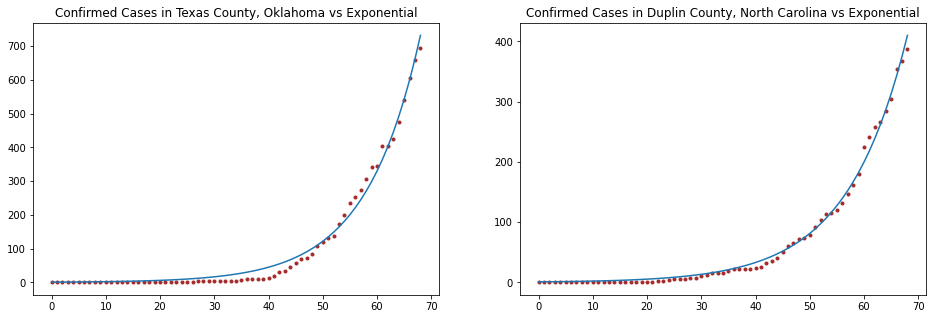

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

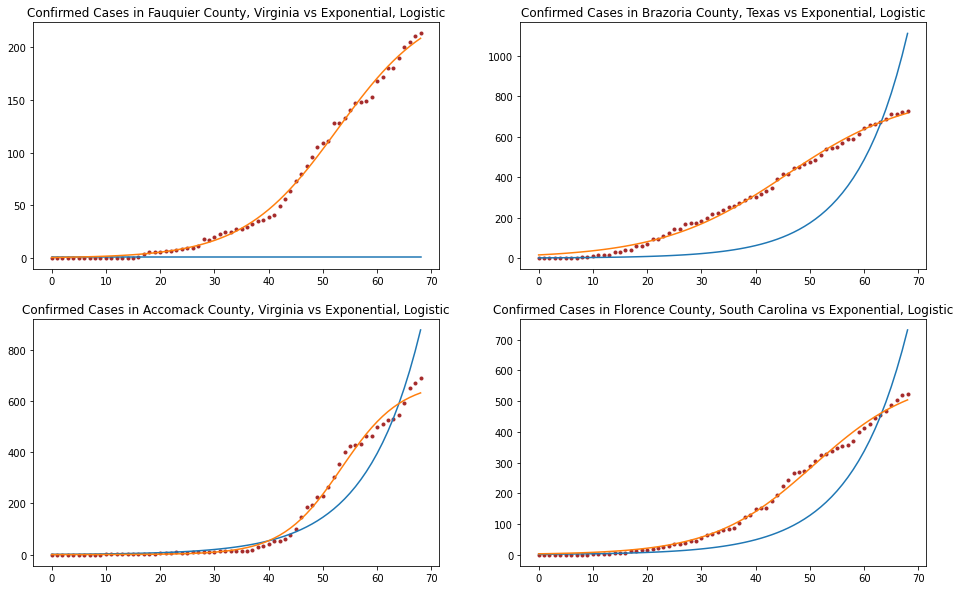

In [11]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

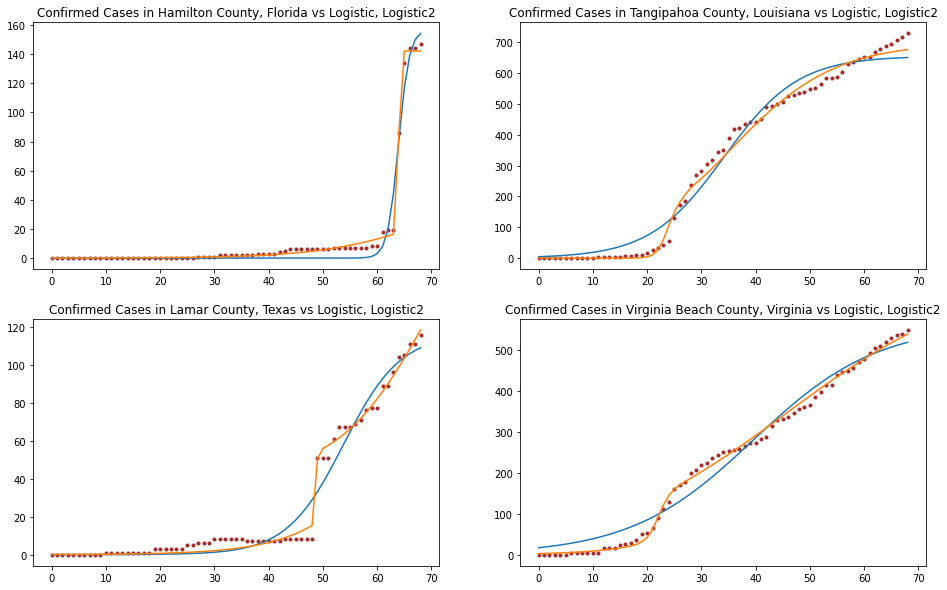

In [12]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [13]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1003,Alabama,Baldwin,223234,535.638267,0.695515,45.357924,519.301303,0.040293,69.000000,21.466305,27.074776
1017,Alabama,Chambers,33254,56.398120,8.364028,29.968907,447.777401,0.020263,17.395100,23.179009,28.260747
1051,Alabama,Elmore,81209,11074.928940,0.267245,69.000000,185.470859,0.000000,68.956724,30.250931,38.458065
1055,Alabama,Etowah,102268,657.444674,6.984353,66.604089,425.439146,0.040748,69.000000,20.125761,23.364314
1069,Alabama,Houston,105882,269.462093,0.194557,41.288964,268.579992,0.048876,69.000000,26.610091,32.808527
...,...,...,...,...,...,...,...,...,...,...,...
55039,Wisconsin,Fond du Lac,103403,21181.628392,0.354152,68.043551,145.315661,0.000000,69.000000,19.068417,27.433458
55089,Wisconsin,Ozaukee,89221,218.872752,0.075339,62.573295,219.948015,0.021983,65.708754,13.410746,17.191139
55127,Wisconsin,Walworth,103868,557.521883,1.133627,53.296243,560.951742,0.046039,69.000000,28.073322,34.988095


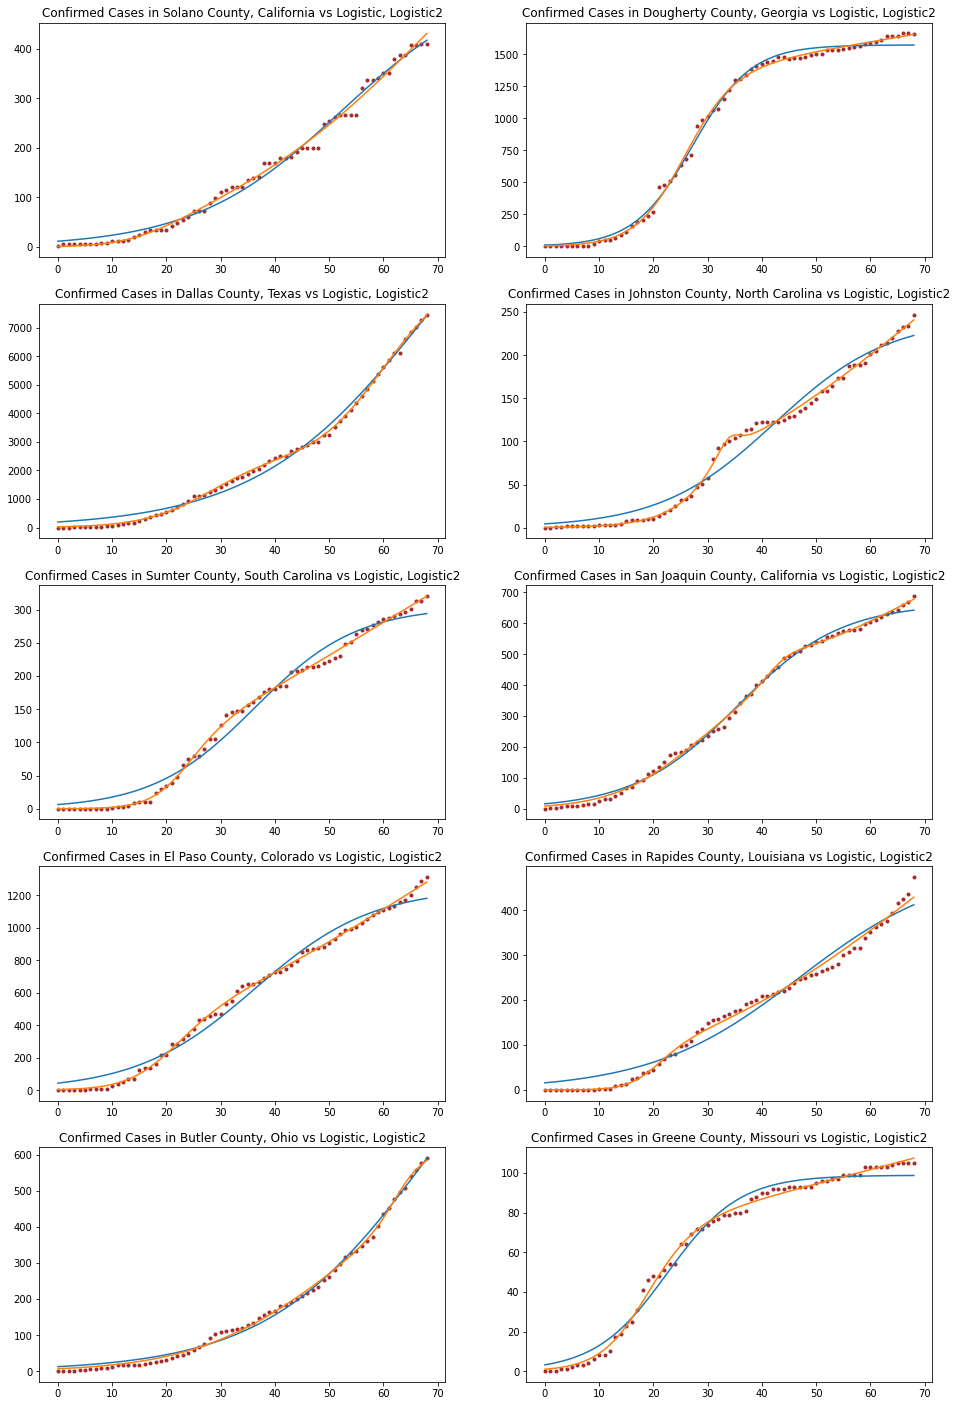

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=10)

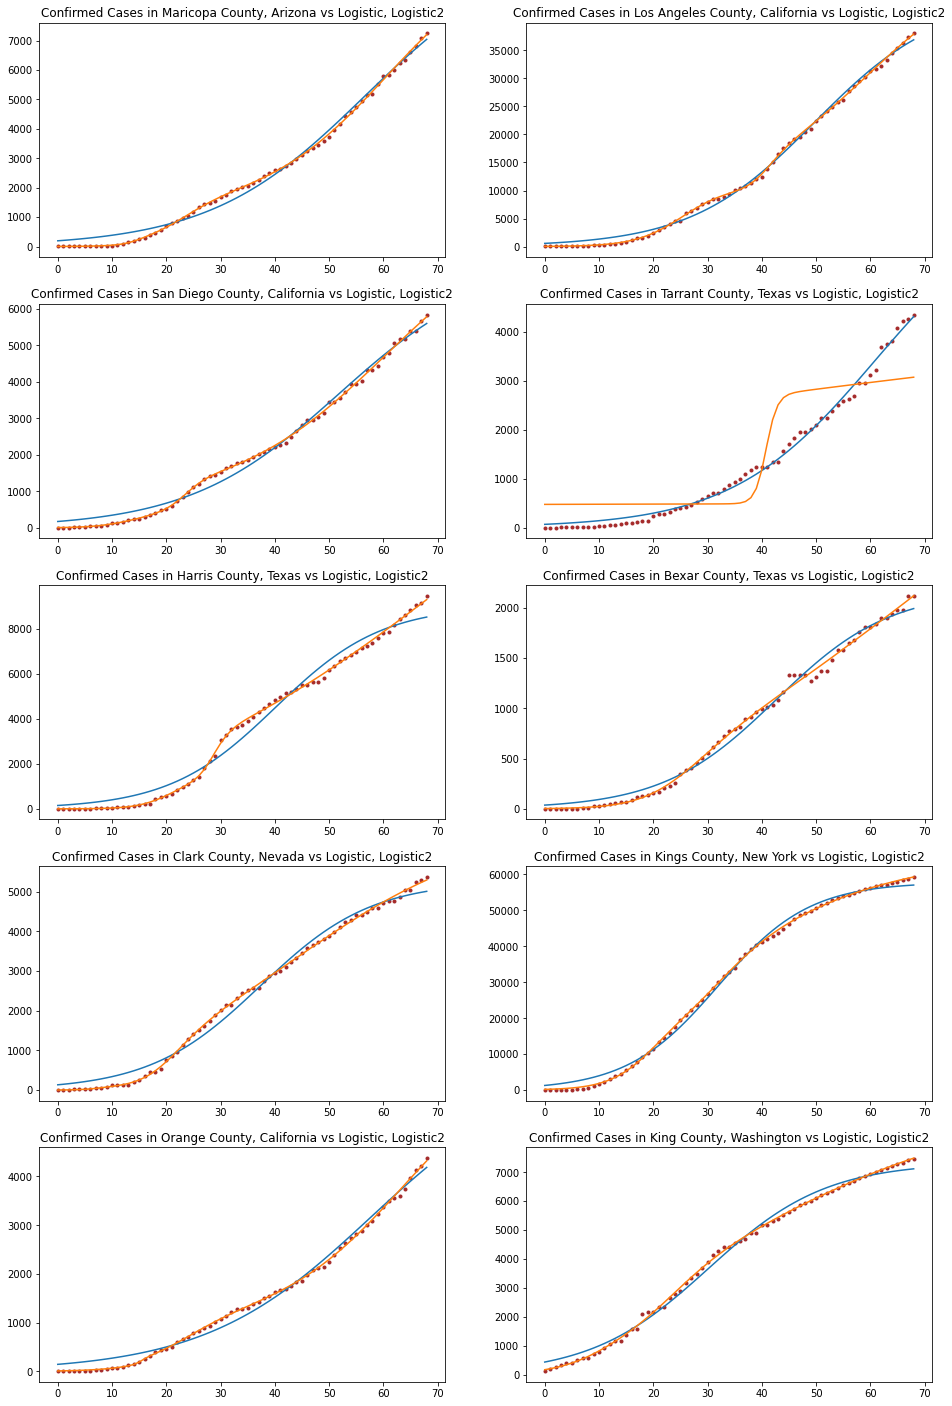

In [15]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [16]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1015,Alabama,Calhoun,113605,-1.383566,0.979270,0.988572
1111,Alabama,Randolph,22722,-1.008847,0.970581,0.988151
4025,Arizona,Yavapai,235099,-0.990882,0.931978,0.954849
4027,Arizona,Yuma,213787,-0.460394,0.987828,0.986823
5123,Arkansas,St. Francis,24994,0.925345,0.914672,0.914823
...,...,...,...,...,...,...
51770,Virginia,Roanoke City,99143,-0.723467,0.979906,0.986830
53053,Washington,Pierce,904980,-0.422945,0.986089,0.756702
55027,Wisconsin,Dodge,87839,-0.860349,0.954302,0.984146


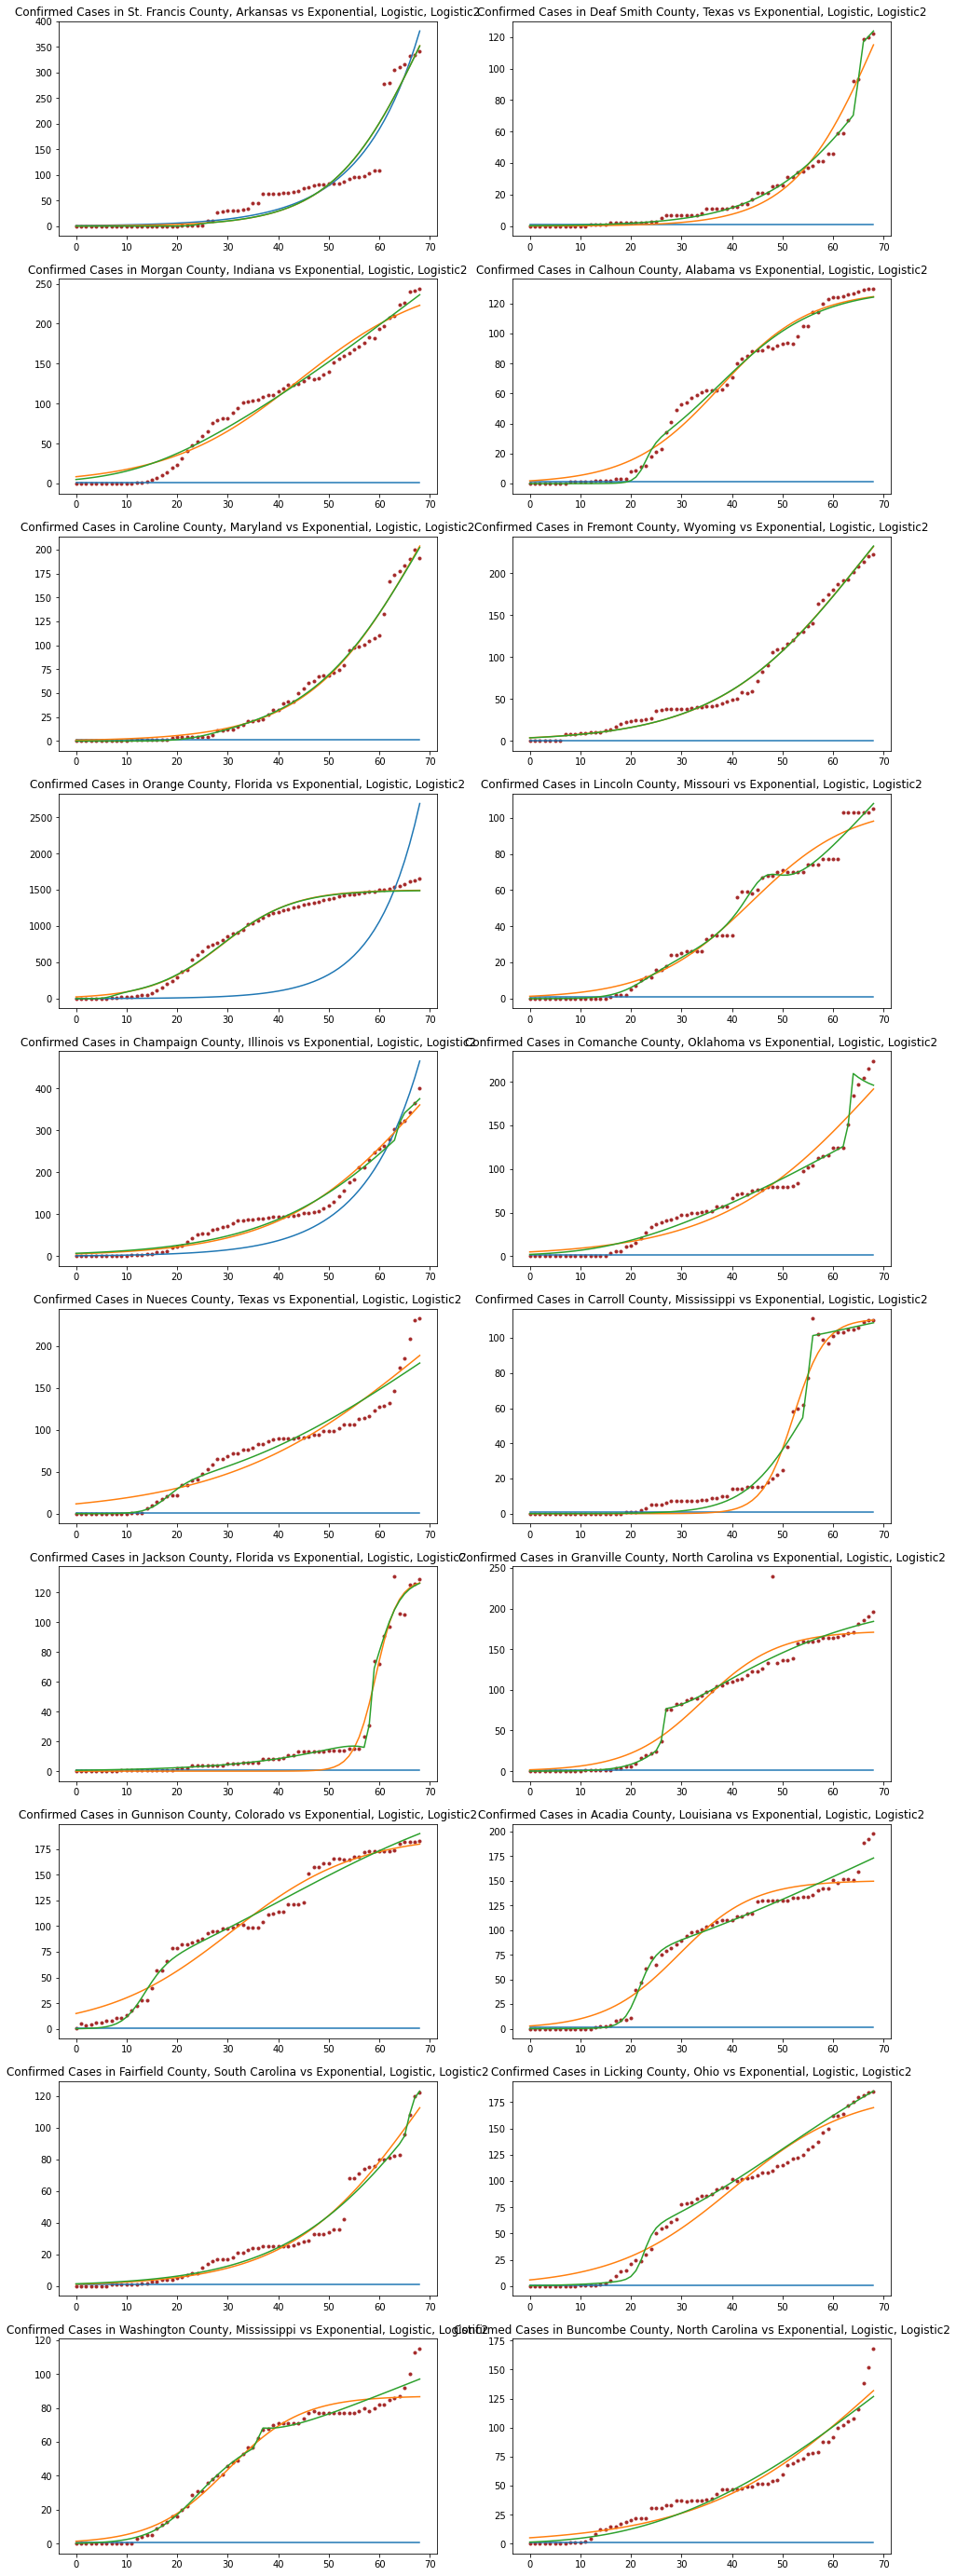

In [17]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)